# Random Forest Regression
## Module import

In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

## Fit default model on different sample windows

In [9]:
# Set the directory containing the CSV files
input_dir = '../../1-preprocessing/data/9-splits/USD'

# Create a DataFrame to store the results
oob_results = pd.DataFrame(columns=['Offset', 'OOB Error'])

train_mape_results = pd.DataFrame(columns=['Offset', 'MAPE'])
train_hitrate_results = pd.DataFrame(columns=['Offset', 'Hitrate'])

test_mape_results = pd.DataFrame(columns=['Offset', 'MAPE'])
test_hitrate_results = pd.DataFrame(columns=['Offset', 'Hitrate'])

train_data = pd.read_csv(os.path.join(input_dir, "train_data.csv"))
test_data = pd.read_csv(os.path.join(input_dir, "test_data.csv"))

# Loop through a given set of time lags
for offset in [1] + [i for i in range(10, 151, 10)]:
    
    # Split the data into features and target
    X_train = train_data.iloc[:, 1:1+5*offset]
    y_train = train_data.iloc[:, -1]
    X_test = test_data.iloc[:, 1:1+5*offset]
    y_test = test_data.iloc[:, -1]

    # Fit the RandomForestRegressor model
    model = RandomForestRegressor(
        n_estimators=100,
        oob_score=True,
        random_state=0,
        max_features=0.3
    )
    
    model.fit(X_train, y_train)
        
    # Calculate the OOB error
    oob_error = 1 - model.oob_score_

    # Predict the test set
    y_test_pred = model.predict(X_test)
    
    
    # Training set prediction evaluation

    # Predict the training set
    y_train_pred = model.predict(X_train)

    # Calculate the Mean Absolute Percentage Error (MAPE)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

    # Calculate the Directional Symmetry (hit rate)
    train_hitrate = (np.sign(y_train_pred) == np.sign(y_train)).mean()

    # Add the results to the DataFrames
    train_mape_results = pd.concat([train_mape_results, pd.DataFrame({'Offset': [offset], 'MAPE': [train_mape]})])
    train_hitrate_results = pd.concat([train_hitrate_results, pd.DataFrame({'Offset': [offset], 'Hitrate': [train_hitrate]})])
    

    # Test set prediction evaluation

    # Predict the test set
    y_test_pred = model.predict(X_test)

    # Calculate the Mean Absolute Percentage Error (MAPE)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    # Calculate the Directional Symmetry (hit rate)
    test_hitrate = (np.sign(y_test_pred) == np.sign(y_test)).mean()

    # Add the results to the DataFrames
    test_mape_results = pd.concat([test_mape_results, pd.DataFrame({'Offset': [offset], 'MAPE': [test_mape]})])
    test_hitrate_results = pd.concat([test_hitrate_results, pd.DataFrame({'Offset': [offset], 'Hitrate': [test_hitrate]})])
    
    # Add the results to the DataFrames
    oob_results = pd.concat([oob_results, pd.DataFrame({'Offset': [offset], 'OOB Error': [oob_error]})])
    
    print(f"{offset}, ", end='')

print()
print('Calculations complete')

1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 
Calculations complete


## Plot results

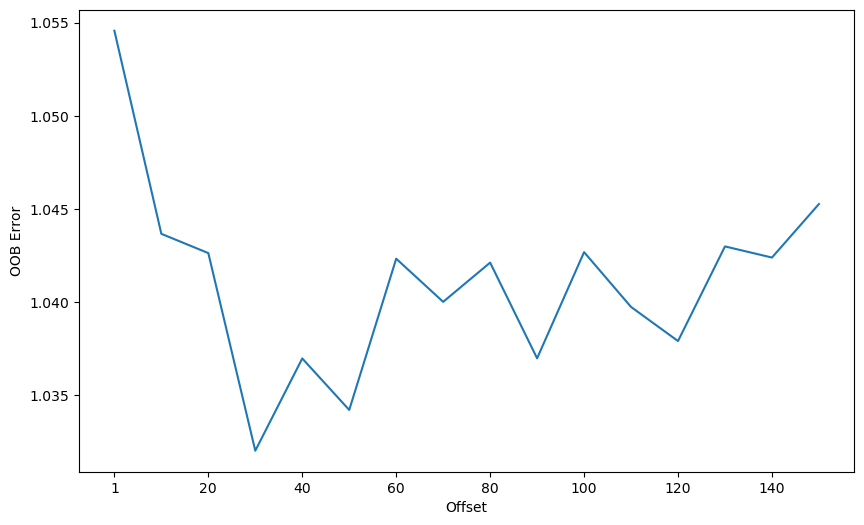

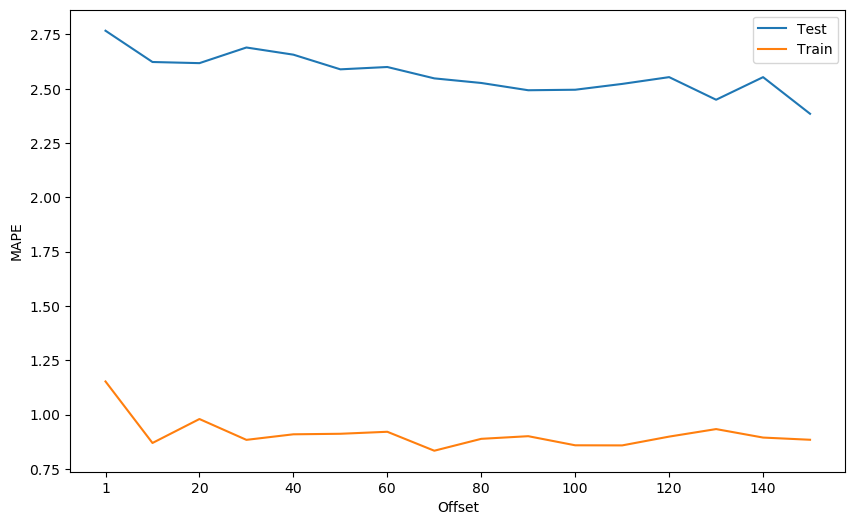

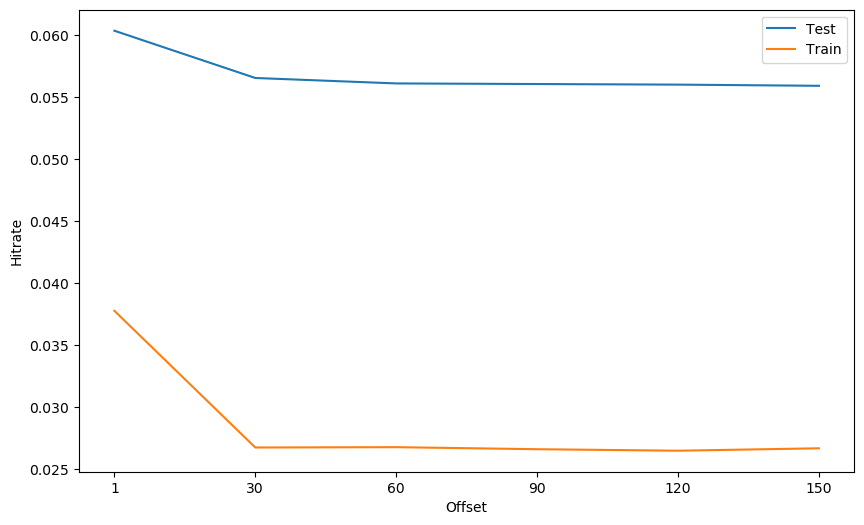

In [10]:
# OOB error

sorted_oob = oob_results.sort_values(by='Offset')
sorted_oob.plot(figsize=(10, 6), x='Offset', ylabel='OOB Error', legend=None)

# MAPE

test_sorted_mape = test_mape_results.sort_values(by='Offset')
train_sorted_mape = train_mape_results.sort_values(by='Offset')

# Individual plots
# test_sorted_mape.plot(title='Test MAPE', x='Offset')
# train_sorted_mape.plot(title='Train MAPE', x='Offset')

fig, ax = plt.subplots(figsize=(10, 6))
test_sorted_mape.plot(x='Offset', ax=ax)
train_sorted_mape.plot(x='Offset', ax=ax)
ax.legend(['Test', 'Train'])
ax.set_xlabel('Offset')
ax.set_ylabel('MAPE')
plt.show()

# Hitrate

test_sorted_hitrate = test_hitrate_results.sort_values(by='Offset')
train_sorted_hitrate = train_hitrate_results.sort_values(by='Offset')

# Individual plots
# test_sorted_hitrate.plot(title='Test Hitrate', x='Offset')
# train_sorted_hitrate.plot(title='Train Hitrate', x='Offset')

fig, ax = plt.subplots(figsize=(10, 6))
test_sorted_mae.plot(x='Offset', ax=ax)
train_sorted_mae.plot(x='Offset', ax=ax)
ax.legend(['Test', 'Train'])
ax.set_xlabel('Offset')
ax.set_ylabel('Hitrate')
plt.show()

## Save results to a CSV file

In [11]:
sorted_oob.to_csv('oob_error_results.csv', index=False)

train_sorted_mape.to_csv('train_mape.csv', index=False)
test_sorted_mape.to_csv('test_mape.csv', index=False)

train_sorted_hitrate.to_csv('train_hitrate.csv', index=False)
test_sorted_hitrate.to_csv('test_hitrate.csv', index=False)